**Importing Data from .mat files**

In [1]:

import scipy.io
import numpy as np

num_trajs = 50
n_bs = 4
n_paths = 25
n_time = 3e3
n_features = 6


mat = scipy.io.loadmat('all_rxpower_tensor_paths.mat')
rx_power_tensor = mat['rx_power_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
rx_power_tensor = np.reshape(rx_power_tensor,(int(num_trajs*n_time),n_bs,n_paths))
rx_power_tensor[rx_power_tensor==0] = -np.infty
rx_power_tensor = 10**(0.1*rx_power_tensor) # in Watts


#print(np.sum((rx_power_tensor==0.0)))
#print(10**(-0.1*np.infty))

print(np.min(rx_power_tensor))

0.0


In [2]:
BW = 400e6
k = 1.38e-23
NF = 10**(0.9)
T = 298

NoisePower = k*BW*NF*T


SNRs = rx_power_tensor/NoisePower

SNRs[SNRs==0.0] = 1e-25 # no paths to -250 dB SNR
print(np.sum((SNRs==1e-25)))


54582


In [3]:

import scipy.io
import numpy as np

num_trajs = 50
n_bs = 4
n_paths = 25
n_time = 3e3
n_features = 6

mat = scipy.io.loadmat('all_azimuth_aoa_tensor_paths.mat')
azimuth_aoa_tensor = mat['azimuth_aoa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
azimuth_aoa_tensor = np.reshape(azimuth_aoa_tensor,(int(num_trajs*n_time),n_bs,n_paths))
azimuth_aoa_tensor = azimuth_aoa_tensor + azimuth_aoa_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))



mat = scipy.io.loadmat('all_azimuth_aod_tensor_paths.mat')
azimuth_aod_tensor = mat['azimuth_aod_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
azimuth_aod_tensor = np.reshape(azimuth_aod_tensor,(int(num_trajs*n_time),n_bs,n_paths))
azimuth_aod_tensor = azimuth_aod_tensor + azimuth_aod_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))

mat = scipy.io.loadmat('all_zenith_aod_tensor_paths.mat')
zenith_aod_tensor = mat['zenith_aod_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
zenith_aod_tensor = np.reshape(zenith_aod_tensor,(int(num_trajs*n_time),n_bs,n_paths))
zenith_aod_tensor = zenith_aod_tensor + zenith_aod_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))


mat = scipy.io.loadmat('all_zenith_aoa_tensor_paths.mat')
zenith_aoa_tensor = mat['zenith_aoa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
zenith_aoa_tensor = np.reshape(zenith_aoa_tensor,(int(num_trajs*n_time),n_bs,n_paths))
zenith_aoa_tensor = zenith_aoa_tensor + zenith_aoa_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))

# mat = scipy.io.loadmat('all_rxpower_tensor_paths.mat')
# rx_power_tensor = mat['rx_power_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
# rx_power_tensor = np.reshape(rx_power_tensor,(int(num_trajs*n_time),n_bs,n_paths))
# rx_power_tensor = 10**(0.1*rx_power_tensor) # in Watts

mat = scipy.io.loadmat('all_toa_tensor_paths.mat')
toa_tensor = mat['toa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
toa_tensor = np.reshape(toa_tensor,(int(num_trajs*n_time),n_bs,n_paths))*1e3 #in ms
toa_tensor = toa_tensor + toa_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))

mat = scipy.io.loadmat('all_true_tensor.mat')
true_cord_tensor = mat['true_cord_tensor'] # dimensions are n_traj x n_time x 3
true_cord_tensor = np.reshape(true_cord_tensor,(int(num_trajs*n_time),3))
del mat


In [4]:
print(azimuth_aoa_tensor.shape)

(150000, 4, 25)


**Constructing the input tensor with dimensions n_samples x n_paths x n_bs x n_features**

In [5]:
import math
input_tensor = np.zeros((int(num_trajs*n_time),n_bs,n_paths,n_features))*math.nan

n_samples = int(num_trajs*n_time)


input_tensor[:,:,:,0] = azimuth_aoa_tensor
del azimuth_aoa_tensor

input_tensor[:,:,:,1] = azimuth_aod_tensor
del azimuth_aod_tensor

input_tensor[:,:,:,2] = zenith_aoa_tensor
del zenith_aoa_tensor

input_tensor[:,:,:,3] = zenith_aod_tensor
del zenith_aod_tensor

input_tensor[:,:,:,4] = rx_power_tensor
del rx_power_tensor

input_tensor[:,:,:,5] = toa_tensor
del toa_tensor

print(np.sum(np.isnan(input_tensor))) ## making sure that there are no values left unassigned

0


In [6]:
import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

input_tensor = np.reshape(input_tensor,(n_samples,int(n_bs*n_paths*n_features)))

**Simple deep neural network approach**

In [7]:
from sklearn import preprocessing


input_tensor = input_tensor 
true_cord_tensor = true_cord_tensor - np.min(true_cord_tensor,axis = 0) ## assuming we know the minimum coordinates
#of UE 
true_cord_tensor = true_cord_tensor*1



model = models.Sequential()
model.add(layers.Dense(400, input_shape=(n_features*n_paths*n_bs,),activation = 'relu'))
model.add(layers.Dense(300,activation = 'relu'))
model.add(layers.Dense(200,activation = 'relu'))
model.add(layers.Dense(300,activation = 'relu'))
model.add(layers.Dense(200,activation = 'relu'))
model.add(layers.Dense(100,activation = 'relu'))
model.add(layers.Dense(3,activation = 'relu'))
print(model.summary())
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(loss='mse', optimizer=opt)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               240400    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               120300    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               60300     
_________________________________________________________________
dense_4 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 3

In [8]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_tensor, true_cord_tensor, test_size=0.5)


scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit(X_train)
scaled_df = scaler.transform(X_train)

In [9]:
model.fit(scaled_df, y_train, epochs=305, batch_size=32, verbose = 2)

Epoch 1/305
2227/2227 - 7s - loss: 8748.6387 - val_loss: 2057.1294
Epoch 2/305
2227/2227 - 6s - loss: 1421.5812 - val_loss: 1051.7478
Epoch 3/305
2227/2227 - 6s - loss: 870.9202 - val_loss: 920.1592
Epoch 4/305
2227/2227 - 6s - loss: 660.6801 - val_loss: 638.4962
Epoch 5/305
2227/2227 - 6s - loss: 521.2226 - val_loss: 617.7757
Epoch 6/305
2227/2227 - 6s - loss: 408.0977 - val_loss: 481.3756
Epoch 7/305
2227/2227 - 6s - loss: 325.7618 - val_loss: 506.6025
Epoch 8/305
2227/2227 - 6s - loss: 269.1425 - val_loss: 420.4940
Epoch 9/305
2227/2227 - 6s - loss: 219.8728 - val_loss: 313.2890
Epoch 10/305
2227/2227 - 6s - loss: 189.4543 - val_loss: 334.1765
Epoch 11/305
2227/2227 - 6s - loss: 160.9955 - val_loss: 313.2230
Epoch 12/305
2227/2227 - 6s - loss: 142.4860 - val_loss: 261.3339
Epoch 13/305
2227/2227 - 6s - loss: 125.7274 - val_loss: 280.0398
Epoch 14/305
2227/2227 - 6s - loss: 104.7708 - val_loss: 318.5286
Epoch 15/305
2227/2227 - 6s - loss: 97.9143 - val_loss: 226.1486
Epoch 16/305
222

2227/2227 - 6s - loss: 3.9123 - val_loss: 341.2219
Epoch 128/305
2227/2227 - 6s - loss: 4.5978 - val_loss: 405.1009
Epoch 129/305
2227/2227 - 6s - loss: 4.6362 - val_loss: 277.9015
Epoch 130/305
2227/2227 - 6s - loss: 9.7033 - val_loss: 456.6584
Epoch 131/305
2227/2227 - 6s - loss: 3.6487 - val_loss: 350.0662
Epoch 132/305
2227/2227 - 6s - loss: 3.3451 - val_loss: 427.4392
Epoch 133/305
2227/2227 - 6s - loss: 4.1994 - val_loss: 397.5408
Epoch 134/305
2227/2227 - 6s - loss: 4.5083 - val_loss: 347.8420
Epoch 135/305
2227/2227 - 6s - loss: 4.2949 - val_loss: 392.8081
Epoch 136/305
2227/2227 - 6s - loss: 8.2577 - val_loss: 392.9297
Epoch 137/305
2227/2227 - 6s - loss: 3.2649 - val_loss: 471.2773
Epoch 138/305
2227/2227 - 6s - loss: 3.3487 - val_loss: 492.2941
Epoch 139/305
2227/2227 - 6s - loss: 3.9534 - val_loss: 534.7968
Epoch 140/305
2227/2227 - 6s - loss: 4.5900 - val_loss: 341.8003
Epoch 141/305
2227/2227 - 6s - loss: 6.5680 - val_loss: 392.3850
Epoch 142/305
2227/2227 - 6s - loss: 3.

Epoch 254/305
2227/2227 - 6s - loss: 5.0523 - val_loss: 415.4503
Epoch 255/305
2227/2227 - 6s - loss: 4.4665 - val_loss: 371.0991
Epoch 256/305
2227/2227 - 6s - loss: 2.3003 - val_loss: 382.9923
Epoch 257/305
2227/2227 - 6s - loss: 1.4191 - val_loss: 431.9386
Epoch 258/305
2227/2227 - 6s - loss: 1.7913 - val_loss: 421.4869
Epoch 259/305
2227/2227 - 6s - loss: 1.8283 - val_loss: 419.7985
Epoch 260/305
2227/2227 - 6s - loss: 1.9403 - val_loss: 405.0325
Epoch 261/305
2227/2227 - 6s - loss: 6.8012 - val_loss: 411.8982
Epoch 262/305
2227/2227 - 6s - loss: 2.2786 - val_loss: 432.4162
Epoch 263/305
2227/2227 - 6s - loss: 1.3532 - val_loss: 429.3300
Epoch 264/305
2227/2227 - 6s - loss: 1.4871 - val_loss: 462.4032
Epoch 265/305
2227/2227 - 6s - loss: 1.8424 - val_loss: 427.4239
Epoch 266/305
2227/2227 - 6s - loss: 1.8088 - val_loss: 373.3053
Epoch 267/305
2227/2227 - 6s - loss: 1.6922 - val_loss: 378.3841
Epoch 268/305
2227/2227 - 6s - loss: 4.6735 - val_loss: 377.8699
Epoch 269/305
2227/2227 -

In [10]:
pred_vals = model.predict(scaler.transform(input_tensor)) +  np.min(true_cord_tensor)*0

pred_train = model.predict(scaled_df)
pred_test = model.predict(scaler.transform(X_test))

In [11]:
#pred_vals = scaler.inverse_transform(pred_vals)
#pred_train = scaler.inverse_transform(pred_train)
#pred_test = scaler.inverse_transform(pred_test)

In [12]:
norm_error = np.linalg.norm(pred_vals - true_cord_tensor,axis = 1)
norm_error_train = np.linalg.norm(pred_train - y_train,axis = 1)
norm_error_test = np.linalg.norm(pred_test - y_test,axis = 1)
print(norm_error.shape)

(150000,)


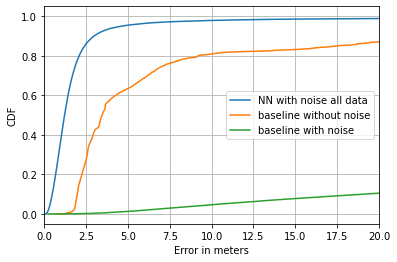

In [13]:
from statsmodels.distributions.empirical_distribution import ECDF

cdf = ECDF(norm_error/1)
plt.plot(cdf.x,cdf.y)
plt.grid()
plt.xlim([0,20])

# cdf = ECDF(norm_error_train/1)
# plt.plot(cdf.x,cdf.y)
# plt.grid()
# plt.xlim([0,20])


# cdf = ECDF(norm_error_test/1)
# plt.plot(cdf.x,cdf.y)
# plt.grid()
# plt.xlim([0,20])


mat = scipy.io.loadmat('baselineerror.mat')
err_data = mat['err_data']
err_data = (err_data).flatten()
cdf = ECDF(err_data*1)
plt.plot(cdf.x,cdf.y)


mat = scipy.io.loadmat('erorwithnoise.mat')
err_data = mat['eroraray']
err_data = (err_data).flatten()
cdf = ECDF(err_data*1)
plt.plot(cdf.x,cdf.y)

plt.xlabel('Error in meters')
plt.ylabel('CDF')
plt.legend(['NN with noise all data','baseline without noise','baseline with noise'])


In [14]:
print(np.mean(norm_error))

3.6364835220770235


In [22]:
cdf = ECDF(norm_error/1)
y = cdf.y
indx = cdf.x[y>0.8]
#print(" {0}":)
print("The 80% percentile error in meters is ", indx[0], end='')

The 80% percentile error in meters is  2.0883613484575867